In [1]:
import tensorflow as tf
import os 
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

2025-03-22 16:26:43.582150: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 16:26:43.600039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742675203.616938   26413 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742675203.621289   26413 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742675203.638245   26413 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
gpu

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [3]:
data_dir = 'data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            #os.remove(image_path)



In [4]:
data = tf.keras.utils.image_dataset_from_directory('data')


Found 457 files belonging to 2 classes.


I0000 00:00:1742675208.157784   26413 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
data_iterator = data.as_numpy_iterator()


In [6]:
batch = data_iterator.next()


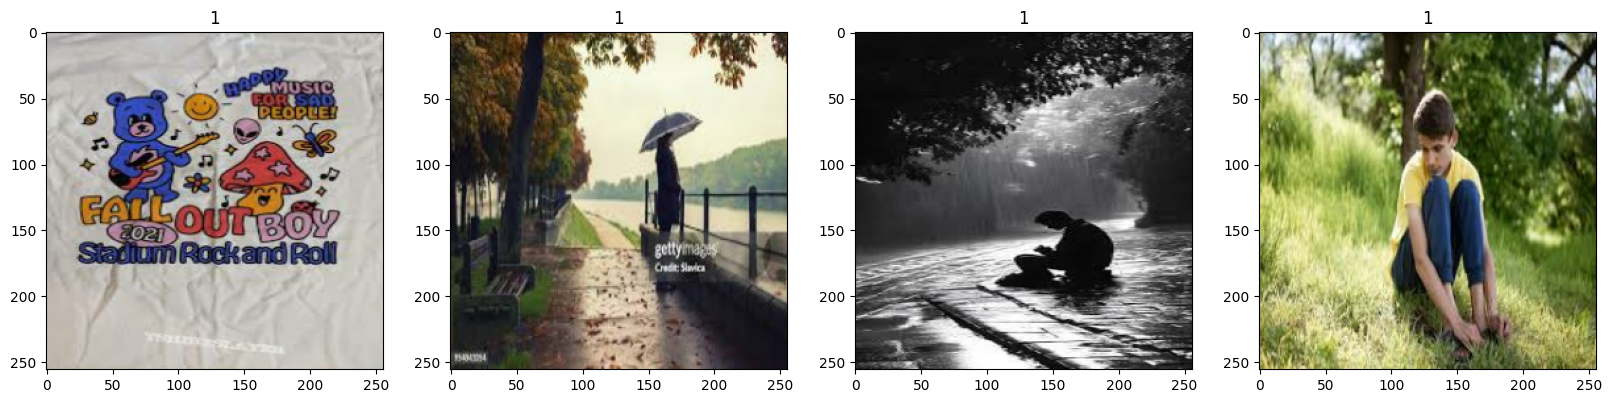

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [8]:
data = data.map(lambda x,y: (x/255, y))


In [9]:
data.as_numpy_iterator().next()


(array([[[[0.54597884, 0.44401807, 0.353822  ],
          [0.6784467 , 0.5760493 , 0.4867264 ],
          [0.698246  , 0.5930913 , 0.50928307],
          ...,
          [0.4800858 , 0.3255285 , 0.29488358],
          [0.37431067, 0.25360754, 0.215265  ],
          [0.28918505, 0.171538  , 0.1323223 ]],
 
         [[0.73340285, 0.6224654 , 0.5300251 ],
          [0.7729389 , 0.6623143 , 0.5707472 ],
          [0.746715  , 0.63889974, 0.5536801 ],
          ...,
          [0.61556935, 0.46043345, 0.423056  ],
          [0.52092737, 0.39399144, 0.3449277 ],
          [0.44810534, 0.32156485, 0.277611  ]],
 
         [[0.9048079 , 0.779363  , 0.6818258 ],
          [0.86971307, 0.74718416, 0.6495614 ],
          [0.8106729 , 0.69453126, 0.6052968 ],
          ...,
          [0.75375956, 0.6006982 , 0.5490723 ],
          [0.6909361 , 0.5513368 , 0.48625284],
          [0.6374874 , 0.49637643, 0.43991545]],
 
         ...,
 
         [[0.01133863, 0.00495773, 0.03691239],
          [0.08295

In [10]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [11]:
train_size

10

In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [13]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [15]:
model = Sequential()


In [16]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

/home/somya/tensorflow_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [18]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,882 (14.10 MB)

 Trainable params: 3,696,882 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
logsdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logsdir)

In [20]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


I0000 00:00:1742675212.968035   26510 service.cc:152] XLA service 0x7fdb90207d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742675212.968128   26510 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-03-22 16:26:53.969398: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742675214.704531   26510 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-22 16:26:55.466447: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_324', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1742675221.565403   26510 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4458 - loss: 1.4986

2025-03-22 16:27:02.936966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33553408 bytes after encountering the first element of size 33553408 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - accuracy: 0.4460 - loss: 1.4329 - val_accuracy: 0.4375 - val_loss: 0.7090
Epoch 2/20
 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4927 - loss: 0.7004

2025-03-22 16:27:04.745014: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4961 - loss: 0.6977

2025-03-22 16:27:05.500783: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5003 - loss: 0.6968 - val_accuracy: 0.6667 - val_loss: 0.6838
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5963 - loss: 0.6868

2025-03-22 16:27:06.804448: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33553408 bytes after encountering the first element of size 33553408 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6001 - loss: 0.6863 - val_accuracy: 0.6042 - val_loss: 0.6730
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6225 - loss: 0.6499 - val_accuracy: 0.6354 - val_loss: 0.6193
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6722 - loss: 0.6334 - val_accuracy: 0.6042 - val_loss: 0.6452
Epoch 6/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6875 - loss: 0.6086

2025-03-22 16:27:09.429009: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.6692 - loss: 0.6058 - val_accuracy: 0.7083 - val_loss: 0.6017
Epoch 7/20


2025-03-22 16:27:10.557179: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7163 - loss: 0.5505 - val_accuracy: 0.6667 - val_loss: 0.6174
Epoch 8/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7500 - loss: 0.5731

2025-03-22 16:27:11.825796: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7051 - loss: 0.5907 - val_accuracy: 0.8229 - val_loss: 0.5048
Epoch 9/20


2025-03-22 16:27:13.077410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7358 - loss: 0.5425 - val_accuracy: 0.7812 - val_loss: 0.4657
Epoch 10/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8438 - loss: 0.4365

2025-03-22 16:27:14.420335: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33553408 bytes after encountering the first element of size 33553408 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7756 - loss: 0.4838

2025-03-22 16:27:15.313231: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7752 - loss: 0.4834 - val_accuracy: 0.8021 - val_loss: 0.4256
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7609 - loss: 0.4876 - val_accuracy: 0.8854 - val_loss: 0.3501
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8319 - loss: 0.4089 - val_accuracy: 0.8750 - val_loss: 0.3197
Epoch 13/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8750 - loss: 0.3190

2025-03-22 16:27:17.684507: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8992 - loss: 0.2973 - val_accuracy: 0.8854 - val_loss: 0.2894
Epoch 14/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7500 - loss: 0.4016

2025-03-22 16:27:18.852346: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8729 - loss: 0.3029 - val_accuracy: 0.9062 - val_loss: 0.2543
Epoch 15/20


2025-03-22 16:27:19.944662: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9072 - loss: 0.2254 - val_accuracy: 0.9375 - val_loss: 0.1639
Epoch 16/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9375 - loss: 0.1519

2025-03-22 16:27:21.129490: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9512 - loss: 0.1674 - val_accuracy: 0.9583 - val_loss: 0.1481
Epoch 17/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0718

2025-03-22 16:27:22.220200: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9734 - loss: 0.1112 - val_accuracy: 0.9583 - val_loss: 0.1233
Epoch 18/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0670

2025-03-22 16:27:23.407312: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9811 - loss: 0.0850 - val_accuracy: 1.0000 - val_loss: 0.0421
Epoch 19/20


2025-03-22 16:27:24.670718: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9815 - loss: 0.1204 - val_accuracy: 0.9792 - val_loss: 0.1092
Epoch 20/20


2025-03-22 16:27:25.739133: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9872 - loss: 0.0863

2025-03-22 16:27:26.769197: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9866 - loss: 0.0864 - val_accuracy: 0.9896 - val_loss: 0.0347


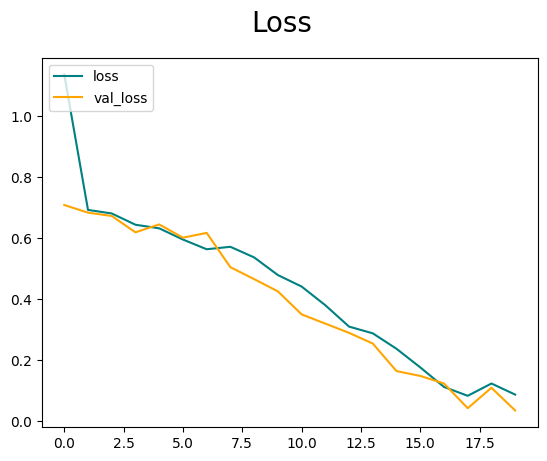

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

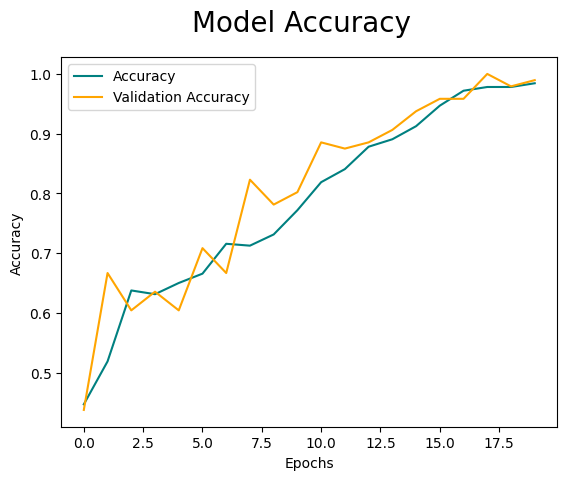

In [22]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
fig.suptitle('Model Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [23]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [24]:

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X) 
    yhat_labels = np.argmax(yhat, axis=1) 

    pre.update_state(y, yhat_labels)
    re.update_state(y, yhat_labels)
    acc.update_state(y, yhat_labels)

print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


2025-03-22 16:27:29.991729: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


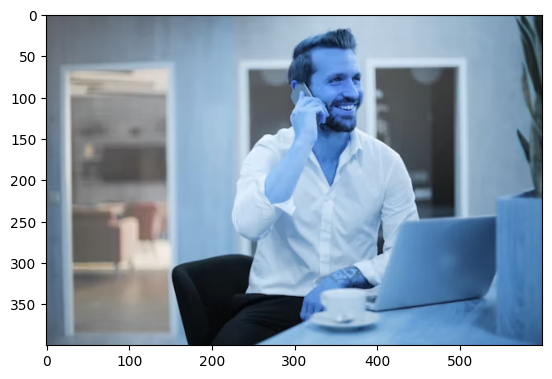

In [25]:
img = cv2.imread('test_image.png')
plt.imshow(img)
plt.show()

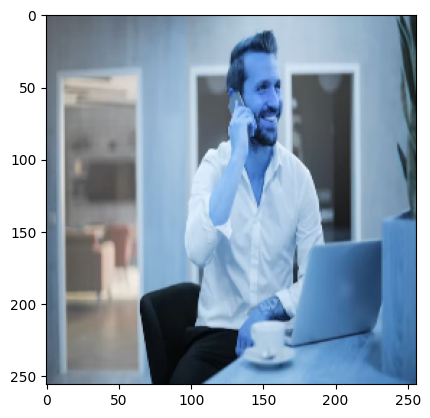

In [26]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [27]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.6453802, 0.3546198]], dtype=float32)

In [28]:
yhat_label = np.argmax(yhat)  

if yhat_label == 1:
    print("Predicted class is Sad")
else:
    print("Predicted class is Happy")


Predicted class is Happy
